In [1]:
# import required libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from sklearn import preprocessing

In [2]:
# read original dataset from file
df = pd.read_csv('/home/fede/workspace/DataLab/python/data/payments_w_distance.txt', sep='|', header=0, decimal=",")

In [3]:
remap = {
    'LUNES': 1,
    'MARTES': 2,
    'MIÉRCOLES': 3,
    'JUEVES': 4, 
    'VIERNES': 5,
    'SÁBADO': 6,
    'DOMINGO': 7
}
df['NUM_DIA_SEMANA'] = df['DIA_SEMANA'].map(remap)

In [4]:
df.FRANJA_HORARIA = pd.to_numeric(df.FRANJA_HORARIA.str.slice(0,2))
df.IMPORTE = df.IMPORTE.astype(float)
df.LAT_CLIENTE = df.LAT_CLIENTE.astype(float)
df.LON_CLIENTE = df.LON_CLIENTE.astype(float)
df.HUMEDAD = df.HUMEDAD.astype(float)
df.SENSAC_TERMICA = df.SENSAC_TERMICA.astype(float)
df.TEMPERATURA = df.TEMPERATURA.astype(float)
df.DISTANCE = df.DISTANCE.astype(float)

In [5]:
#df_restauracion = df[df.SECTOR == 'RESTAURACION']

In [6]:
from sklearn.cross_validation import train_test_split
data_train, data_test = train_test_split(df, test_size=.3, random_state=1234)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data_train_num = data_train.select_dtypes(include=numerics)

In [8]:
del data_train_num['CP_CLIENTE']
del data_train_num['CP_COMERCIO']
del data_train_num['TIMESTAMP']
del data_train_num['LAT_CLIENTE']
del data_train_num['LON_CLIENTE']
del data_train_num['HUMEDAD']
del data_train_num['SENSAC_TERMICA']
del data_train_num['TEMPERATURA']
del data_train_num['NUM_DIA_SEMANA']
del data_train_num['FRANJA_HORARIA']
del data_train_num['NUM_OP']
data_train_num.head()

,IMPORTE,DISTANCE
2984619,16.60,2.605903
1301869,21.45,2.441470
828235,63.73,34.138472
410755,76.37,0.000000
2965294,93.70,5.549250


In [9]:
data_train_norm = data_train_num.copy()

In [10]:
#data_train_norm.FRANJA_HORARIA = preprocessing.scale(data_train_norm.FRANJA_HORARIA.astype('float64'))
data_train_norm.IMPORTE = preprocessing.scale(data_train_norm.IMPORTE.astype('float64'))
data_train_norm.DISTANCE = preprocessing.scale(data_train_norm.DISTANCE.astype('float64'))

In [11]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
clusters = range(1,16)
meandist = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(data_train_norm)
    predict = model.predict(data_train_norm)
    meandist.append(sum(np.min(cdist(data_train_norm, model.cluster_centers_, 'euclidean'), axis=1))/data_train.shape[0])

In [12]:
plt.plot(clusters, meandist)
plt.xlabel('number clusters')
plt.ylabel('distance')
plt.title('Choose k number of clusters')

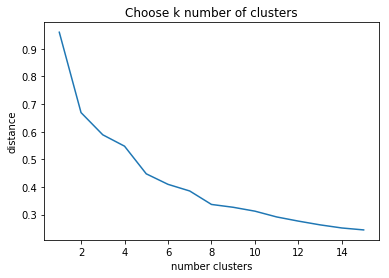

In [13]:
plt.show()

In [14]:
model = KMeans(n_clusters=8)
model.fit(data_train_norm)
predict = model.predict(data_train_norm)

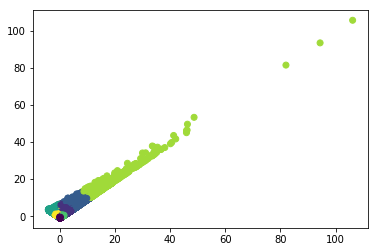

In [15]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
pca_plot = pca_2.fit_transform(data_train_norm)
plt.scatter(x=pca_plot[:,0], y=pca_plot[:,1], c=model.labels_)
plt.show()

In [16]:
from pandas import DataFrame
data_train_norm.reset_index(inplace=True, level=0)
index = list(data_train.index)
labels = list(model.labels_)
newlist = dict(zip(index, labels))
clust = DataFrame.from_dict(newlist, orient='index')

In [17]:
clust.columns = ['CLUSTER']

In [18]:
data_train['CLUSTER'] = clust.CLUSTER

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
print(data_train.groupby('CLUSTER').mean())

           CP_CLIENTE   CP_COMERCIO  FRANJA_HORARIA      IMPORTE    NUM_OP  \
CLUSTER                                                                      
0        46134.934204  46012.600213       14.529082    30.790978  1.214463   
1        46178.426309  46013.061185       14.567906   424.793805  6.082581   
2        46217.422976  46012.694219       14.049910  1002.667934  7.355059   
3        46391.125663  46011.579158       14.650808    32.311894  1.103196   
4        46564.232157  46011.794371       14.963557    42.422858  1.093404   
5        46168.082438  46012.466499       14.611396   154.974552  2.625835   
6        46250.610802  46011.212073       13.763304  2540.030334  2.615568   
7        46359.641029  46011.605839       14.904627    42.506889  1.112371   

         LAT_CLIENTE  LON_CLIENTE     TIMESTAMP   HUMEDAD  SENSAC_TERMICA  \
CLUSTER                                                                     
0          39.473658    -0.381860  1.452549e+09  0.572296       1

In [20]:
data_train[data_train.CLUSTER==1].describe(include='all')

,CP_CLIENTE,CP_COMERCIO,SECTOR,DIA,FRANJA_HORARIA,IMPORTE,NUM_OP,CIUDAD_CLIENTE,LAT_CLIENTE,LON_CLIENTE,...,FECHA,TIMESTAMP,HUMEDAD,SENSAC_TERMICA,TEMPERATURA,TIEMPO_DESC,DIA_SEMANA,DISTANCE,NUM_DIA_SEMANA,CLUSTER
count,53935.000000,53935.000000,53935,53935,53935.000000,53935.000000,53935.000000,53935,53935.000000,53935.000000,...,53935,5.393500e+04,53935.000000,53935.000000,53935.000000,53935,53935,53935.000000,53935.000000,53935.0
unique,NaN,NaN,11,731,NaN,NaN,NaN,208,NaN,NaN,...,5725,NaN,NaN,NaN,NaN,9,7,NaN,NaN,NaN
top,NaN,NaN,ALIMENTACION,2016-11-25,NaN,NaN,NaN,Valencia,NaN,NaN,...,2016-11-25 18:00:00,NaN,NaN,NaN,NaN,Despejado,VIERNES,NaN,NaN,NaN
freq,NaN,NaN,16063,226,NaN,NaN,NaN,32687,NaN,NaN,...,58,NaN,NaN,NaN,NaN,40576,9733,NaN,NaN,NaN
mean,46178.426309,46013.061185,NaN,NaN,14.567906,424.793805,6.082581,NaN,39.462392,-0.427708,...,NaN,1.452424e+09,0.567753,19.999817,19.904791,NaN,NaN,9.121534,3.694836,1.0
std,275.798077,7.055139,NaN,NaN,3.925194,110.820017,7.440111,NaN,0.110520,0.127755,...,NaN,1.845487e+07,0.169012,6.844333,6.522213,NaN,NaN,14.119031,1.788282,0.0
min,46001.000000,46001.000000,NaN,NaN,0.000000,273.680000,1.000000,NaN,38.756121,-1.462804,...,NaN,1.420067e+09,0.100000,-2.900000,-0.140000,NaN,NaN,0.000000,1.000000,1.0
25%,46014.000000,46007.000000,NaN,NaN,12.000000,330.835000,1.000000,NaN,39.447137,-0.419588,...,NaN,1.436184e+09,0.450000,14.660000,14.660000,NaN,NaN,0.000000,2.000000,1.0
50%,46022.000000,46014.000000,NaN,NaN,16.000000,398.990000,2.000000,NaN,39.470414,-0.388962,...,NaN,1.452272e+09,0.560000,19.410000,19.410000,NaN,NaN,2.605903,4.000000,1.0
75%,46197.000000,46019.000000,NaN,NaN,18.000000,500.000000,11.000000,NaN,39.498783,-0.372482,...,NaN,1.467986e+09,0.680000,25.220000,25.220000,NaN,NaN,12.391919,5.000000,1.0


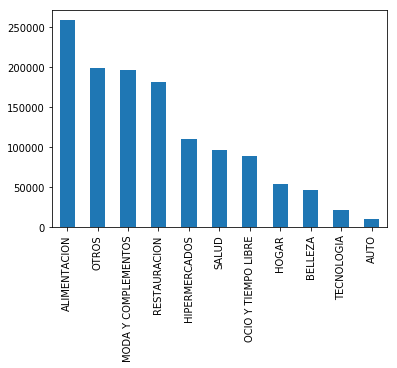

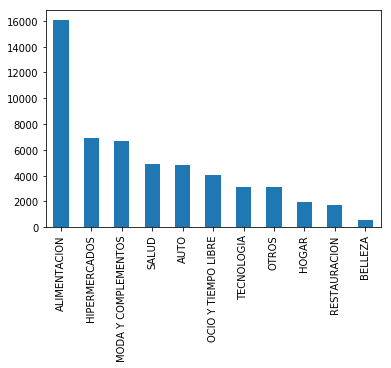

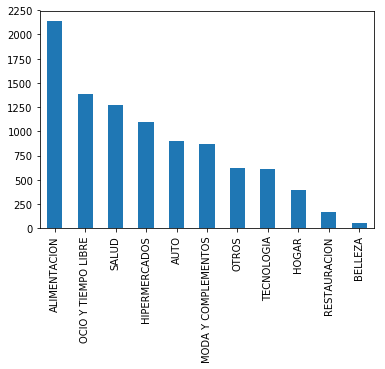

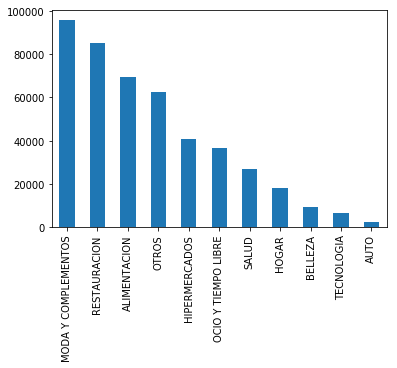

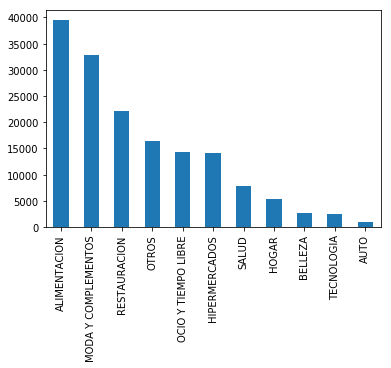

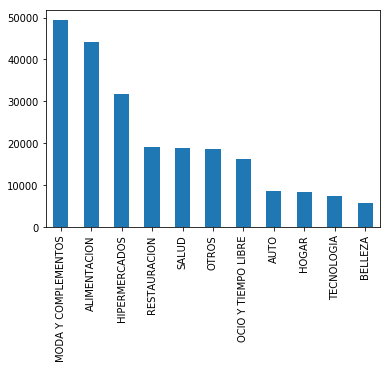

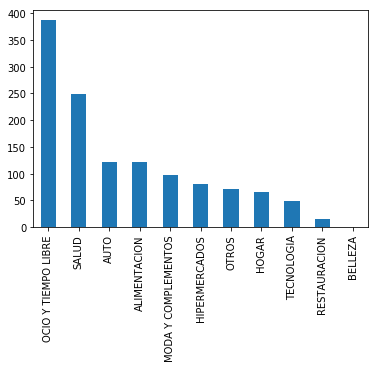

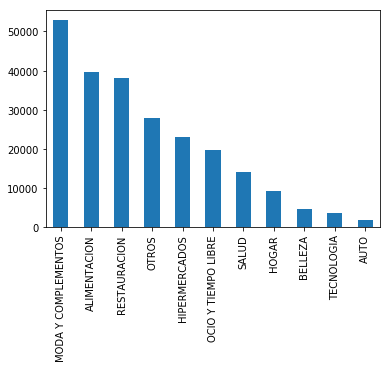

In [24]:
data_train[data_train.CLUSTER==0].SECTOR.value_counts().plot(kind='bar')
plt.show()
data_train[data_train.CLUSTER==1].SECTOR.value_counts().plot(kind='bar')
plt.show()
data_train[data_train.CLUSTER==2].SECTOR.value_counts().plot(kind='bar')
plt.show()
data_train[data_train.CLUSTER==3].SECTOR.value_counts().plot(kind='bar')
plt.show()
data_train[data_train.CLUSTER==4].SECTOR.value_counts().plot(kind='bar')
plt.show()
data_train[data_train.CLUSTER==5].SECTOR.value_counts().plot(kind='bar')
plt.show()
data_train[data_train.CLUSTER==6].SECTOR.value_counts().plot(kind='bar')
plt.show()
data_train[data_train.CLUSTER==7].SECTOR.value_counts().plot(kind='bar')
plt.show()

In [66]:
data_train[data_train.CLUSTER==1].describe(include='all')

,CP_CLIENTE,CP_COMERCIO,SECTOR,DIA,FRANJA_HORARIA,IMPORTE,NUM_OP,CIUDAD_CLIENTE,LAT_CLIENTE,LON_CLIENTE,...,LON_COMERCIO,FECHA,TIMESTAMP,HUMEDAD,SENSAC_TERMICA,TEMPERATURA,TIEMPO_DESC,DIA_SEMANA,NUM_DIA_SEMANA,CLUSTER
count,25641.000000,25641.000000,25641,25641,25641.000000,25641.000000,25641.000000,25641,25641.000000,25641.000000,...,25641,25641,2.564100e+04,25641.000000,25641.000000,25641.000000,25641,25641,25641.000000,25641.0
unique,NaN,NaN,1,607,NaN,NaN,NaN,52,NaN,NaN,...,21,3967,NaN,NaN,NaN,NaN,8,7,NaN,NaN
top,NaN,NaN,ALIMENTACION,2015-09-26,NaN,NaN,NaN,Valencia,NaN,NaN,...,-0.39602750000000003,2015-12-24 12:00:00,NaN,NaN,NaN,NaN,Despejado,SÁBADO,NaN,NaN
freq,NaN,NaN,25641,67,NaN,NaN,NaN,25301,NaN,NaN,...,2690,20,NaN,NaN,NaN,NaN,18087,4585,NaN,NaN
mean,46019.267813,46015.110370,NaN,NaN,14.842947,277.006429,10.963223,NaN,39.470372,-0.376960,...,NaN,NaN,1.451910e+09,0.562204,20.196934,20.083682,NaN,NaN,3.535627,1.0
std,42.086695,6.728799,NaN,NaN,3.690569,100.729426,3.838645,NaN,0.023574,0.027935,...,NaN,NaN,1.824511e+07,0.167429,6.888720,6.536316,NaN,NaN,1.725392,0.0
min,46001.000000,46001.000000,NaN,NaN,2.000000,67.830000,1.000000,NaN,38.934437,-1.231362,...,NaN,NaN,1.420189e+09,0.100000,-2.900000,-0.140000,NaN,NaN,1.000000,1.0
25%,46009.000000,46009.000000,NaN,NaN,12.000000,200.150000,8.000000,NaN,39.456080,-0.388962,...,NaN,NaN,1.435918e+09,0.440000,14.900000,14.900000,NaN,NaN,2.000000,1.0
50%,46017.000000,46015.000000,NaN,NaN,14.000000,261.560000,10.000000,NaN,39.470414,-0.380721,...,NaN,NaN,1.452244e+09,0.550000,19.740000,19.740000,NaN,NaN,4.000000,1.0
75%,46021.000000,46021.000000,NaN,NaN,18.000000,341.970000,14.000000,NaN,39.484527,-0.358361,...,NaN,NaN,1.467389e+09,0.680000,25.580000,25.580000,NaN,NaN,5.000000,1.0


In [67]:
data_train[data_train.CLUSTER==2].describe(include='all')

,CP_CLIENTE,CP_COMERCIO,SECTOR,DIA,FRANJA_HORARIA,IMPORTE,NUM_OP,CIUDAD_CLIENTE,LAT_CLIENTE,LON_CLIENTE,...,LON_COMERCIO,FECHA,TIMESTAMP,HUMEDAD,SENSAC_TERMICA,TEMPERATURA,TIEMPO_DESC,DIA_SEMANA,NUM_DIA_SEMANA,CLUSTER
count,8097.000000,8097.000000,8097,8097,8097.000000,8097.000000,8097.000000,8097,8097.000000,8097.000000,...,8097,8097,8.097000e+03,8097.000000,8097.000000,8097.000000,8097,8097,8097.000000,8097.0
unique,NaN,NaN,1,600,NaN,NaN,NaN,15,NaN,NaN,...,19,2327,NaN,NaN,NaN,NaN,7,6,NaN,NaN
top,NaN,NaN,ALIMENTACION,2016-12-23,NaN,NaN,NaN,Valencia,NaN,NaN,...,-0.39602750000000003,2015-11-07 12:00:00,NaN,NaN,NaN,NaN,Despejado,SÁBADO,NaN,NaN
freq,NaN,NaN,8097,44,NaN,NaN,NaN,7912,NaN,NaN,...,2035,14,NaN,NaN,NaN,NaN,6364,2362,NaN,NaN
mean,46020.343090,46016.505249,NaN,NaN,14.364579,675.166772,23.108559,NaN,39.470792,-0.384933,...,NaN,NaN,1.453957e+09,0.576166,19.364500,19.312263,NaN,NaN,3.974188,2.0
std,35.607113,5.844451,NaN,NaN,3.759109,331.529739,6.915405,NaN,0.023089,0.022082,...,NaN,NaN,1.848670e+07,0.166988,6.423162,6.175594,NaN,NaN,1.826653,0.0
min,46001.000000,46001.000000,NaN,NaN,4.000000,307.830000,1.000000,NaN,38.892223,-0.857982,...,NaN,NaN,1.420196e+09,0.100000,2.280000,3.560000,NaN,NaN,1.000000,2.0
25%,46014.000000,46014.000000,NaN,NaN,12.000000,499.820000,20.000000,NaN,39.452075,-0.396028,...,NaN,NaN,1.438106e+09,0.450000,14.240000,14.240000,NaN,NaN,2.000000,2.0
50%,46017.000000,46017.000000,NaN,NaN,12.000000,590.830000,22.000000,NaN,39.467655,-0.388962,...,NaN,NaN,1.454519e+09,0.570000,18.720000,18.720000,NaN,NaN,4.000000,2.0
75%,46022.000000,46022.000000,NaN,NaN,18.000000,735.070000,26.000000,NaN,39.484527,-0.373658,...,NaN,NaN,1.469290e+09,0.690000,24.200000,24.200000,NaN,NaN,6.000000,2.0
